In [7]:
from glob import glob
from pathlib import Path

import cv2 
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from keras.applications.mobilenet import preprocess_input
import tensorflow as tf
from tensorflow.keras.models import Model

from SNN.shared_nearest_neighbors import SNN
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, accuracy_score, precision_score, recall_score
from sklearn import preprocessing

from finder.utils import load_model, construct_dataset

plt.style.use('seaborn')

def parse(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

def construct_dataset(fnames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((fnames, labels))
    dataset = dataset.map(parse, num_parallel_calls=4)
    # dataset = dataset.shuffle(len(fnames))
    dataset = dataset.batch(24)
    dataset = dataset.prefetch(1)
    return dataset

def embed(img):
    embeddings = model(img)
    normalized = preprocessing.normalize(embeddings, norm='l2')
    return normalized

def _metrics(true, pred):
    acc = accuracy_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    # print(f'Acc: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
    return acc, precision, recall

In [2]:
# construct dataset
fnames = []
labels = []

root = './data'
brands = glob(f'{root}/*')

count = 0
for brand in brands:
    print(f"Adding {brand.split('/')[-1]} to dataset as label {count}")
    items = glob(f'{brand}/*')
    fnames += items
    labels += [count] * len(items)
    count += 1
assert len(fnames) == len(labels)

Adding dfd3e756-84ab-4265-ba92-6c052d1b09a3 to dataset as label 0
Adding 9703c845-7d31-4bf6-8146-917ca7bc1d39 to dataset as label 1
Adding dfc7da50-3a9d-4c77-a4bf-5b1f3105f10e to dataset as label 2
Adding 9683e268-78c6-45a5-827f-bf5c6584281f to dataset as label 3
Adding 0a2ac933-f473-49b1-baa7-3825696e2e7f to dataset as label 4
Adding dfe1496a-8243-4d47-8a4e-7a2db437bd08 to dataset as label 5
Adding e6e2f7a0-2671-4ba4-a069-956df1d2d1e9 to dataset as label 6
Adding dfe2d9e7-be4f-4986-9ce9-a20e8ccd346b to dataset as label 7
Adding dff69293-73ed-48f7-aa13-b491d3da6131 to dataset as label 8
Adding 9706ed74-9fb0-4605-8c48-a5bb0691fa79 to dataset as label 9
Adding 9646a030-d132-4f9e-8862-8a8426eb4116 to dataset as label 10
Adding dfd06b13-ac9c-4815-b4c1-18be0c40bbf1 to dataset as label 11
Adding dff82797-71d7-49ef-8c93-5fe2d0061432 to dataset as label 12
Adding dfed2a20-2223-46e0-83e0-d5f9d6068afc to dataset as label 13
Adding dfbf1846-daa3-4830-9a67-b06ebbc01046 to dataset as label 14
Addin

In [3]:
# load pretrained model to compute embeddings
embedding_layer = 'feature_vector' 
model_path = Path("./model/0050-0.868171.hdf5")
m = tf.keras.models.load_model(model_path)
model = Model(inputs=m.input, outputs=m.get_layer(embedding_layer).output)

2022-02-28 10:02:03.626005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# construct dataset
dataset = construct_dataset(fnames, labels)
train_data = np.vstack([embed(X) for X, y in dataset])
print(f'We have {train_data.shape[0]} samples with {train_data.shape[1]}-dim embeddings')

We have 678 samples with 1024-dim embeddings


In [5]:
# compute similarity matrix so we can identify nearest neighbors through brute force
sim_matrix = pairwise_distances(train_data, metric='euclidean')
print(f'shape {sim_matrix.shape}')

shape (678, 678)


In [15]:
params = [50, 75, 100]
idxs = [15, 31, 300]

mean_precision = []

for n_results in tqdm(params):
    print(f'Top {n_results} results')
    
    batch = []

    for idx in idxs:

        indices = pd.Series(sim_matrix[idx]).sort_values(ascending=True).index.values[:n_results]  # first element is itself
        results = np.take(train_data, indices, axis=0)  # neighbor embeddings

        y_test = np.take(labels, indices)
        y_test_encoded = (y_test == labels[idx]).astype(int)  # 1 represents same cluster as query image, 0 for everything else

        # ground truth cluster
        t = TSNE(n_components=2)
        projections = t.fit_transform(results)

        # plot points with cluster labels
        snn = SNN(n_neighbors=3, eps=0.1, min_samples=5, metric="euclidean")  # tighter eps give better results
        snn.fit(results)
        snn_labels = snn.labels_
        snn_pred = (snn_labels == snn_labels[0]).astype(int)  # first element is itself
        acc, precision, recall = _metrics(true=y_test_encoded, pred=snn_pred)
        
        batch.append(acc)
    
    mean_precision.append(np.mean(batch))

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Top 50 results


/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.p

Top 75 results


/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.p

Top 100 results


/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vintang/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.p

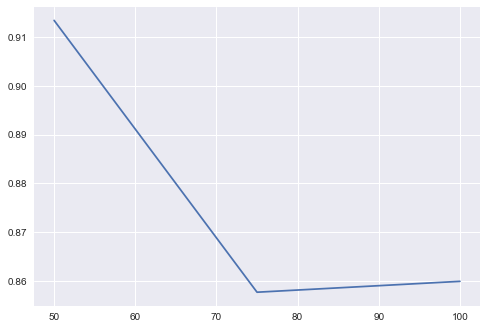

In [17]:
plt.plot(params, mean_precision)